# Исследование рынка заведений общественного питания Москвы

## Задача

Подготовить исследование рынка общественного питания Москвы на основе открытых данных о заведениях общественного питания. Исследование должно отвечать на вопросы:

* Как соотносятся виды и сетевая принадлежность объектов общественного питания по количеству?
* Для каких видов объектов характерно сетевое распространение?
* Какие особенности характерны для сетевых заведений?
* Существуют ли характерные особенности у объектов разного вида? Какие?
* Какие улицы и районы Москвы являются популярными среди объектов общественного питания? На каких расположено только 1 заведение?
* Какие особенности объектов характерны для популярных улиц?

## Оглавление

* [Предобработка данных](#start)
    * [Общий вывод](#start_conclusions)
    
    
* [Анализ данных](#analysis)
    * [Определение улицы и района](#det_str_dis)
    * [Cоотношение видов объектов общественного питания по количеству](#task_1)
    * [Соотношение сетевых и несетевых заведений по количеству](#task_2)
    * [Характерные особенности сетевых заведений](#task_3)
    * [Характерные особеннсоти объектов в разрезе их вида](#task_4)
    * [Популярные улицы и районы Москвы среди объектов](#task_5)
    * [Районы Москвы с преобладающим числом одного заведения на одной улице](#task_6)
    * [Распределение количества посадочных мест для улиц с большим количеством объектов](#task_7)
    
    
* [Выводы](#conclusions)

## Решение

### Предобработка данных <a id="start"></a>

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from io import BytesIO
import requests as req

import re

Сразу определим размер шрифта подписей графиков

In [2]:
plt.rcParams.update({'font.size': 14})

Считаем данные о заведениях общественного питания Москвы

In [3]:
path = 'datasets/'
file_name = 'rest_data.csv'

data = pd.read_csv(path + file_name)

Взглянем на 3 рандомные строки датасета

In [4]:
data.sample(3)

,id,object_name,chain,object_type,address,number
12112,190124,Милти,да,магазин (отдел кулинарии),"город Москва, Живописная улица, дом 12, корпус 1",4
15331,211208,Милти,да,кафе,"город Москва, Дубининская улица, дом 41, строе...",0
13687,211999,Кулинариум экспресс,нет,магазин (отдел кулинарии),"город Москва, улица Шаболовка, дом 65, корпус 1",0


И общую информацию о датасете

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Датафрейм состоит из 6-ти св-в объектов, где:

* id - уникальный идентификатор объекта;
* object_name — название объекта общественного питания;
* chain — сетевой ресторан;
* object_type — тип объекта общественного питания;
* address — адрес;
* number — количество посадочных мест.

Приведем столбцы с типом данных <code>object</code> (кроме <code>address</code>) к нижнему регистру

In [6]:
for col in data.columns[1:4]:
    data[col] = data[col].str.lower()

In [7]:
data.sample()

,id,object_name,chain,object_type,address,number
5875,27288,корчма,нет,ресторан,"город Москва, Рязанский проспект, дом 65, корп...",98


Проверим датасет на наличие явных дублей

In [8]:
data.duplicated().sum()

0

Проверим словарь <code>chain</code>

In [9]:
data['chain'].unique()

array(['нет', 'да'], dtype=object)

Проверим словарь <code>object_type</code>

In [10]:
data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

**Примечание**: в дальнейшем необходимо будет строить различные графики, которые отражают тип объекта. Для большего удобства переименуем 'предприятие быстрого обслуживания' в 'пбо', а 'магазин (отдел кулинарии)' в 'отдел кулинарии'. Так подписи не будут слишком длинными

In [11]:
def rename_func(name):
    if name == 'предприятие быстрого обслуживания':
        return 'пбо'
    
    if name == 'магазин (отдел кулинарии)':
        return 'отдел кулинарии'
    
    return name
    
data['object_type'] = data['object_type'].apply(rename_func)

Проверим результат переименования

In [12]:
data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная', 'пбо', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'отдел кулинарии'], dtype=object)

Проверим число уникальных заведений по названию

In [13]:
data['object_name'].nunique()

9924

#### Общий вывод <a id="start_conclusions"></a>

* Типы данных определены верно. Для <code>chain</code> и <code>object_type</code> лучше использовать словари (с int8 ключом), однако при данной величине датасета это не повлияет на скорость обработки результатов
* Пропуски, явные и неявные дубли в словарях не обнаружены
* Уникальных типов заведений - 9
* Уникальных названий около 2/3 от их общего числа

### Анализ данных <a id="analysis"></a>

#### Определение улицы и района <a id="det_str_dis"></a>

В рамках задачи необходимо определить улицу и район представленных в датасете заведений. Данная задача была решена отдельно, ознакомиться с ней можно <a href='https://github.com/stas-chuprinskiy/praktikum_projects/tree/master/get-adress-info-geocoder' alt='github-stas-chuprinskiy'>тут</a>. Результат решения задачи - csv файл, в котором для каждого уникального адреса из <code>address</code> определены координаты заведения, улица и район.

Загрузим данную таблицу из google spreadsheets в <code>data_address</code>

In [14]:
sheet_id = '1BQdyuHov5N66gOX8dI-HNtQ8R2CScEQLCpc-KIPkEsU'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(sheet_id)

response = req.get(file_name)
data_address = pd.read_csv(BytesIO(response.content))

И взглянем на несколько строк этого датафрейма

In [15]:
data_address.sample(3)

,Unnamed: 0,address,coordinates,address_det,street,district
620,620,"город Москва, Новгородская улица, дом 26",37.580804 55.901818,"Россия, Москва, Новгородская улица, 26",['Новгородская улица'],"['Северо-Восточный административный округ', 'р..."
322,322,"город Москва, Кантемировская улица, дом 17, ко...",37.671166 55.636717,"Россия, Москва, Кантемировская улица, 17к1",['Кантемировская улица'],"['Южный административный округ', 'район Царицы..."
5513,5513,"город Москва, улица Орджоникидзе, дом 5",37.600918 55.709931,"Россия, Москва, улица Орджоникидзе, 5",['улица Орджоникидзе'],"['Южный административный округ', 'Донской район']"


Дропнем 1ый столбец и взглянем на общую информацию о датасете

In [16]:
data_address = data_address.drop(data_address.columns[0], axis=1)

In [17]:
data_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9108 entries, 0 to 9107
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   address      9108 non-null   object
 1   coordinates  9108 non-null   object
 2   address_det  9108 non-null   object
 3   street       9108 non-null   object
 4   district     9108 non-null   object
dtypes: object(5)
memory usage: 355.9+ KB


В датафрейме собрана информация для 9108 адресов. Как отмечалось в выводах решения задачи по определению адресов и районов:

* Для 8-ми адресов в <code>data_address</code> город и все сопутствующие метаданные адреса были определены неверно
* Отсутствующие значения, т.е. пустые [] - особенности адреса, а не ошибки

Проверим число уникальных адресов в <code>address</code>

In [18]:
data['address'].nunique()

9108

Число строк в исходной таблице <code>data</code> и полученной в результате решения задачи <code>data_address</code> совпадают. Объединим таблицы по общему полю <code>address</code>

In [19]:
data_co = data.merge(data_address, on='address', how='left')

Взглянем на несколько строк результирующего датафрейма и общую информацию о нём

In [20]:
data_co.sample(3)

,id,object_name,chain,object_type,address,number,coordinates,address_det,street,district
2048,124969,попкорн бар,нет,бар,"город Москва, улица Бахрушина, дом 25",12,37.63738 55.73296,"Россия, Москва, улица Бахрушина, 25",['улица Бахрушина'],"['Центральный административный округ', 'район ..."
12428,204321,бистро «бак-бук»,нет,кафе,"город Москва, улица Покровка, дом 2/1, строение 1",36,37.639051 55.757992,"Россия, Москва, улица Покровка, 2/1с1",['улица Покровка'],['Центральный административный округ']
11093,179670,шаурма,нет,пбо,"город Москва, проезд Дежнёва, владение 23Б",0,37.63756 55.87041,"Россия, Москва, проезд Дежнёва, вл23Б",['проезд Дежнёва'],"['Северо-Восточный административный округ', 'р..."


In [21]:
data_co.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 0 to 15365
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
 6   coordinates  15366 non-null  object
 7   address_det  15366 non-null  object
 8   street       15366 non-null  object
 9   district     15366 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.3+ MB


Объединение прошло успешно: пустых значений не обнаружено. Осталось убедиться в том, что 8-ми неверным адресам в <code>data_address</code> не соответствует большое число неверных строк в <code>data_co</code>

In [22]:
flag = 0

def moscow_det(elem):
    global flag
    if not (elem.find('Россия, Москва,') >= 0):
        flag = flag + 1

data_co['address_det'].apply(moscow_det)

flag

12

Для 12 объектов в <code>data_co</code> координаты, улица и район определены неверно. Оставим эти заведения как есть - не думаю, что они существенно исказят результаты анализа

#### Cоотношение видов объектов общественного питания по количеству <a id="task_1"></a>

Перед построением графиков зададим общую палитру

In [23]:
# Взглянуть на палитру можно так
# current_palette = sns.color_palette("icefire", 20)
# print(sns.palplot(current_palette))

sns.set_palette('icefire')

Перед исследованием договоримся, что:

* Отметка в <code>chain</code> "да" означает принадлежность объекта к сетевому
* Одинаковые названия объектов говорят о принадлежности их к одной сети

Для ответа на вопрос подготовим данные - сгруппируем <code>data_co</code> по <code>object_type</code> и <code>chain</code>

In [24]:
data_co_pivot = data_co.pivot_table(
    index='object_type',
    values='id',
    columns='chain',
    aggfunc='count'
).reset_index()

data_co_pivot

chain,object_type,да,нет
0,бар,37,819
1,буфет,11,574
2,закусочная,56,304
3,кафе,1396,4703
4,кафетерий,52,346
5,отдел кулинарии,78,195
6,пбо,791,1132
7,ресторан,544,1741
8,столовая,3,2584


Определим суммарное кол-во заведений в разрезе каждого типа

In [25]:
data_co_pivot['count'] = data_co_pivot.sum(axis=1)

data_co_pivot

chain,object_type,да,нет,count
0,бар,37,819,856
1,буфет,11,574,585
2,закусочная,56,304,360
3,кафе,1396,4703,6099
4,кафетерий,52,346,398
5,отдел кулинарии,78,195,273
6,пбо,791,1132,1923
7,ресторан,544,1741,2285
8,столовая,3,2584,2587


Переименуем столбцы и выведем в порядке убывания общего числа заведений определенного типа

In [26]:
data_co_pivot.columns = ['object_type', 'chain_yes', 'chain_no', 'count']

data_co_pivot.sort_values(by='count', ascending=False)

,object_type,chain_yes,chain_no,count
3,кафе,1396,4703,6099
8,столовая,3,2584,2587
7,ресторан,544,1741,2285
6,пбо,791,1132,1923
0,бар,37,819,856
1,буфет,11,574,585
4,кафетерий,52,346,398
2,закусочная,56,304,360
5,отдел кулинарии,78,195,273


Построим график соотношения видов объектов общественного питания по количеству. Для этого определим ф-ию <code>barplot_func()</code>

In [27]:
def barplot_func(data, x, y, rotation=90, hue='hue', hue_bol=False, title='Title', xlabel='x', ylabel='y', style='darkgrid', despine=False):
    sns.set_style(style)
    
    if despine:
        sns.despine()
        
    plt.figure(figsize=(12, 8))
    
    if hue_bol:
        ax = sns.barplot(data=data, x=x, y=y, hue=hue)
    else:
        ax = sns.barplot(data=data, x=x, y=y)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.tick_params(axis='x', rotation=rotation)
    ax.set_ylabel(ylabel)
    
    plt.show()

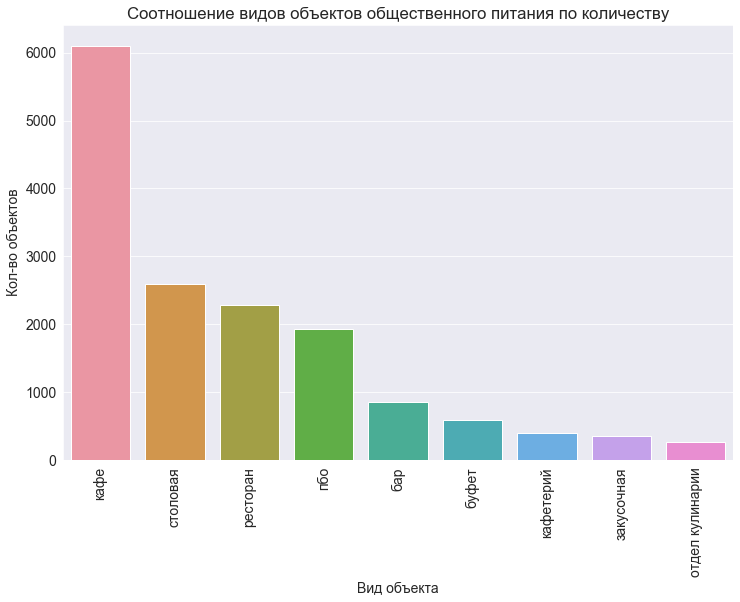

In [28]:
barplot_func(
    data = data_co_pivot.sort_values(by='count', ascending=False),
    x='object_type',
    y='count',
    title='Cоотношение видов объектов общественного питания по количеству',
    xlabel='Вид объекта',
    ylabel='Кол-во объектов'
)

**Выводы**

* Наиболее популярный вид объекта – кафе. По популярности превосходит другие виды более чем в 2 раза
* Следующая по популярности группа: столовая, ресторан, предприятие быстрого обслуживания 
* Остальные виды объектов имеют низкую относительную популярность

#### Соотношение сетевых и несетевых заведений по количеству <a id="task_2"></a>

На этот вопрос более правильно отвечать в разрезе видов объектов. Для каждого вида объекта определим долю сетевых заведений

In [29]:
data_co_pivot['chain_rate'] = (data_co_pivot['chain_yes'] / data_co_pivot['count'] * 100).round(2)

data_co_pivot.sort_values(by='chain_rate', ascending=False)

,object_type,chain_yes,chain_no,count,chain_rate
6,пбо,791,1132,1923,41.13
5,отдел кулинарии,78,195,273,28.57
7,ресторан,544,1741,2285,23.81
3,кафе,1396,4703,6099,22.89
2,закусочная,56,304,360,15.56
4,кафетерий,52,346,398,13.07
0,бар,37,819,856,4.32
1,буфет,11,574,585,1.88
8,столовая,3,2584,2587,0.12


Визуализируем данные с помощью <code>barplot_func()</code>

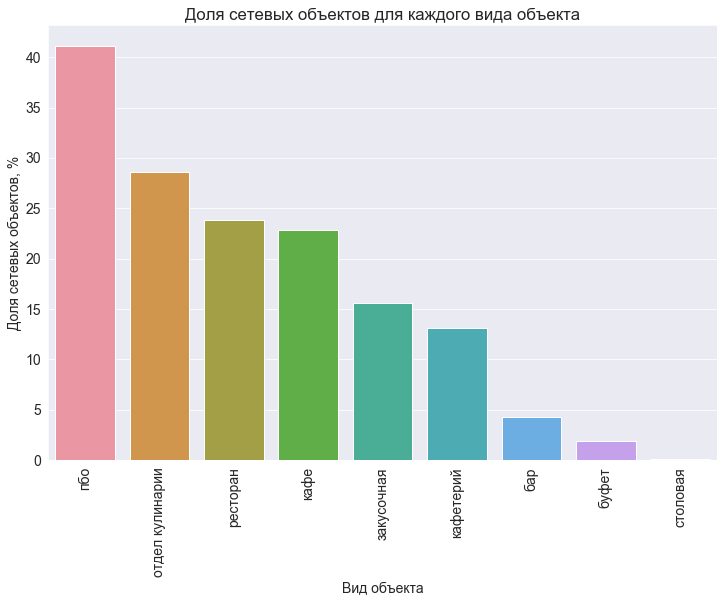

In [30]:
barplot_func(
    data_co_pivot.sort_values(by='chain_rate', ascending=False),
    x='object_type',
    y='chain_rate',
    title='Доля сетевых объектов для каждого вида объекта',
    xlabel='Вид объекта',
    ylabel='Доля сетевых объектов, %'
)

**Выводы**

* Сетевое распространение характерно для предприятий быстрого обслуживания. Чуть более 40% пбо – сети
* Объекты вида кафе и ресторан имеют долю сетевых объектов от 20 до 25%
* Для столовых не характерно сетевое распространение - доля сетей подобного вида объектов менее 1%

#### Характерные особенности сетевых заведений <a id="task_3"></a>

Исследуем что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Первично выделим сетевые заведения в <code>chain_data_co</code>

In [31]:
chain_data_co = data_co.query('chain == "да"')

Взглянем на общую взаимосвязь кол-ва заведений и среднего кол-ва посадочных мест в них. Для этого сгруппируем данные по <code>object_name</code>, посчитаем кол-во заведений и среднее число посадочных мест

In [32]:
(
    chain_data_co
    .groupby('object_name')
    .agg({'id':'count', 'number':'mean'})
    .reset_index()
).sample(3)

,object_name,id,number
55,the terrace,1,45.0
118,васаби,1,0.0
40,paul поль,2,38.0


Визуализируем зависимость полученных параметров. Для этого определим ф-ию <code>regplot_func()</code>

In [33]:
def regplot_func(data, x, y, title='Title', xlabel='x', ylabel='y', style='darkgrid', despine=False):
    sns.set_style(style)
    
    if despine:
        sns.despine()
        
    plt.figure(figsize=(12, 10))
    
    ax = sns.regplot(data=data, x=x, y=y)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylabel(ylabel)
    
    plt.show()

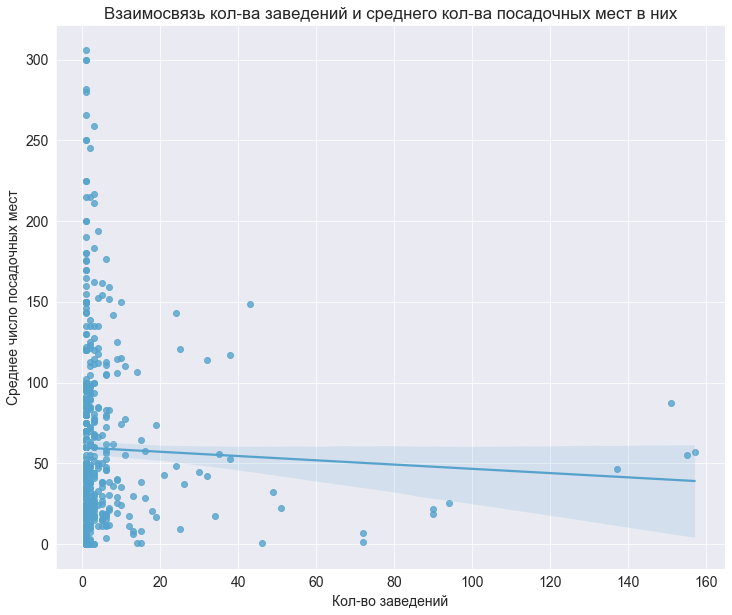

In [34]:
regplot_func(
    data=(
        chain_data_co
        .groupby('object_name')
        .agg({'id':'count', 'number':'mean'})
        .reset_index()
    ),
    x='id',
    y='number',
    title='Взаимосвязь кол-ва заведений и среднего кол-ва посадочных мест в них',
    xlabel='Кол-во заведений',
    ylabel='Среднее число посадочных мест',
)

В каждом параметре наблюдаются выбросы. Отсечем:

* Сети с кол-вом заведений более 40
* Сети с числом посадочных мест более 200

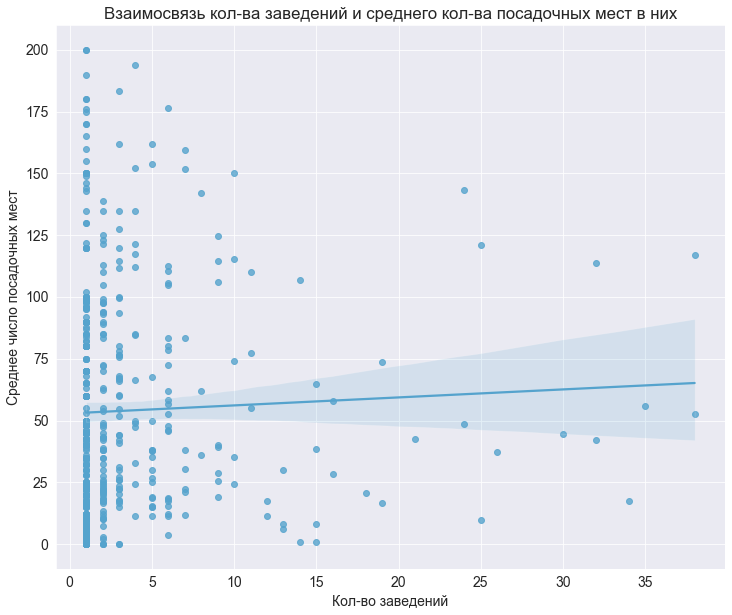

In [35]:
regplot_func(
    data=(
        chain_data_co
        .groupby('object_name')
        .agg({'id':'count', 'number':'mean'})
        .reset_index()
    ).query('id <= 40 and number <= 200'),
    x='id',
    y='number',
    title='Взаимосвязь кол-ва заведений и среднего кол-ва посадочных мест в них',
    xlabel='Кол-во заведений',
    ylabel='Среднее число посадочных мест'
)

Определим коэффицент корреляции для исследуемых параметров

In [36]:
(
    chain_data_co
    .groupby('object_name')
    .agg({'id':'count', 'number':'mean'})
    .reset_index()
).query('id <= 40 and number <= 200').corr()

,id,number
id,1.000000,0.037868
number,0.037868,1.000000


Построим распределение кол-ва заведений в сети. Для этого определим ф-ию <code>distplot_func</code>

In [37]:
def distplot_func(a, bins=50, kde=False, title='Title', xlabel='x', ylabel='y', style='darkgrid', despine=False):
    sns.set_style(style)
    
    if despine:
        sns.despine()
        
    plt.figure(figsize=(12, 10))
    
    ax = sns.distplot(a=a, bins=bins, kde=kde)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylabel(ylabel)
    
    plt.show()

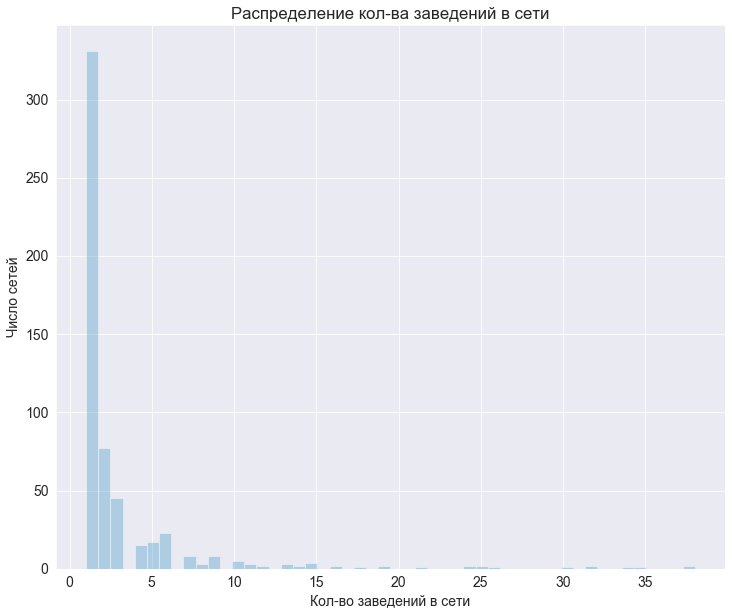

In [38]:
distplot_func(
    a=(
        chain_data_co
        .groupby('object_name')
        .agg({'id':'count', 'number':'mean'})
        .reset_index()
    ).query('id <= 40')['id'],
    title='Распределение кол-ва заведений в сети',
    xlabel='Кол-во заведений в сети',
    ylabel='Число сетей'
)

**Выводы**

* Общей взаимосвязи между кол-вом заведений и средним числом посадочных мест в них для сетевых объектов не наблюдается
* Сетевым заведениям характерно низкое кол-во объектов в сети: более 75% сетевых заведений имеют до 3 объектов в сети
* Характер числа посадочных мест стоит рассматривать в разрезе видов объектов

Для основных видов объектов:

In [39]:
['кафе', 'ресторан', 'пбо'] # Для столовых нехарактерна сетевая принадлежность, поэтому в списке нет

['кафе', 'ресторан', 'пбо']

Построим распределения кол-ва посадочных мест

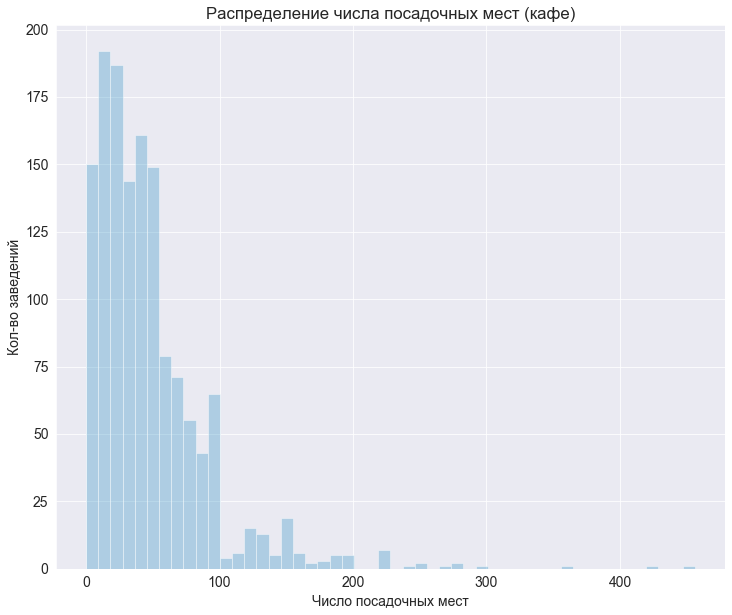

Числовое описание данных распределения посадочных мест (кафе)
count    1396.000000
mean       47.426934
std        44.731453
min         0.000000
25%        20.000000
50%        40.000000
75%        60.000000
max       456.000000
Name: number, dtype: float64


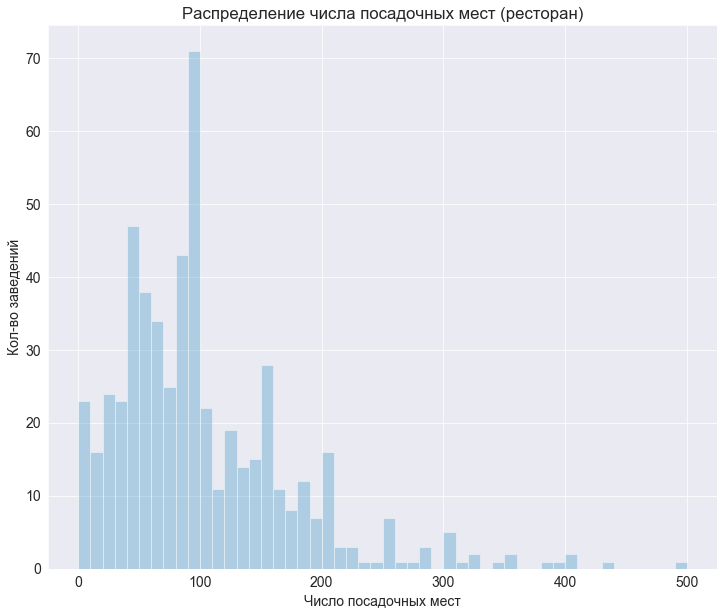

Числовое описание данных распределения посадочных мест (ресторан)
count    544.000000
mean     100.233456
std       74.434805
min        0.000000
25%       50.000000
50%       88.500000
75%      136.500000
max      500.000000
Name: number, dtype: float64


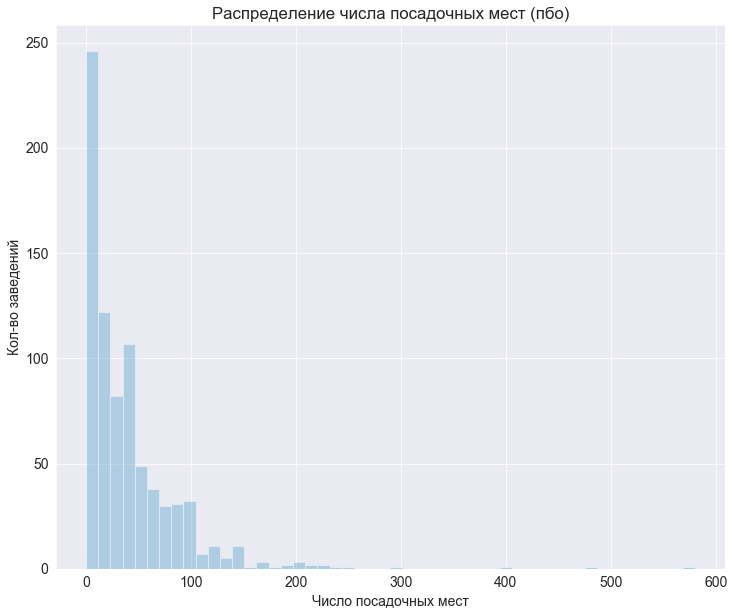

Числовое описание данных распределения посадочных мест (пбо)
count    791.000000
mean      40.166877
std       50.703132
min        0.000000
25%        8.000000
50%       25.000000
75%       52.000000
max      580.000000
Name: number, dtype: float64


In [40]:
for object_type in ['кафе', 'ресторан', 'пбо']:
    data = chain_data_co.query('object_type == @object_type')
    number = data['number']
    
    distplot_func(
        a=number,
        title='Распределение числа посадочных мест ({})'.format(object_type),
        xlabel='Число посадочных мест',
        ylabel='Кол-во заведений'
    )
    
    print('Числовое описание данных распределения посадочных мест ({})'.format(object_type))
    print(number.describe())

Для каждого вида объекта характерны выбросы по кол-ву посадочных мест. Тогда для каждого распределения определим верхнюю границу, как <code>up_rate * q3</code>, где q3 - третий квантиль. В результате построения будем также вычислять результат - среднее кол-во посадочных мест для исследуемых типов сетевых объектов. Характеристикой среднего будет являться медианное значение, т.к. распределения не являются равномерными. Результат сохраним в <code>result</code>

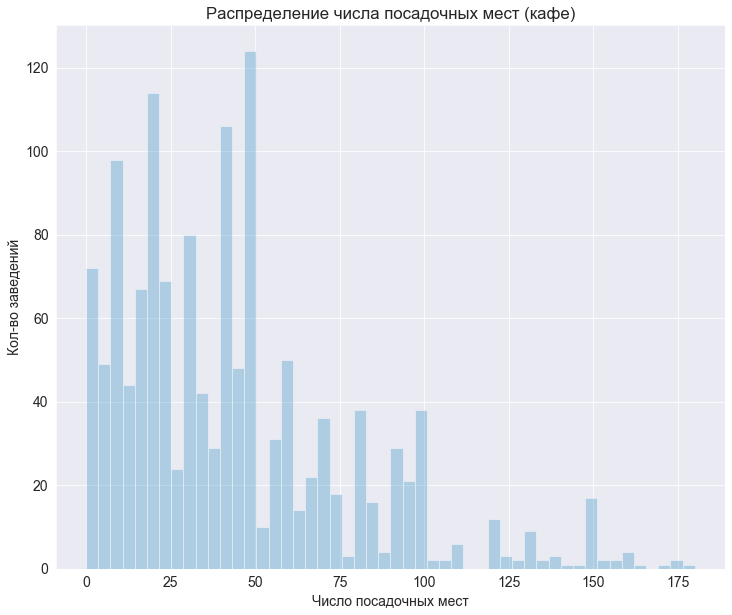

Числовое описание данных распределения посадочных мест (кафе)
count    1369.000000
mean       43.545654
std        34.176693
min         0.000000
25%        19.000000
50%        38.000000
75%        60.000000
max       180.000000
Name: number, dtype: float64


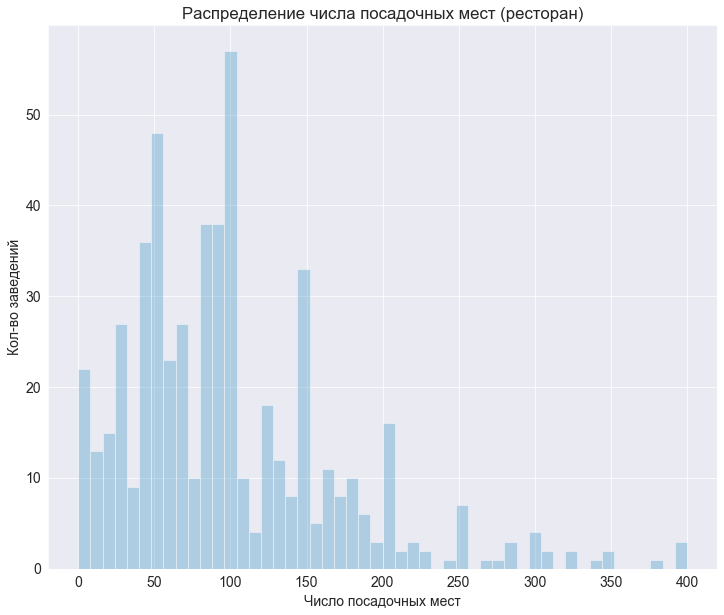

Числовое описание данных распределения посадочных мест (ресторан)
count    542.000000
mean      98.887454
std       71.153321
min        0.000000
25%       50.000000
50%       88.000000
75%      134.500000
max      400.000000
Name: number, dtype: float64


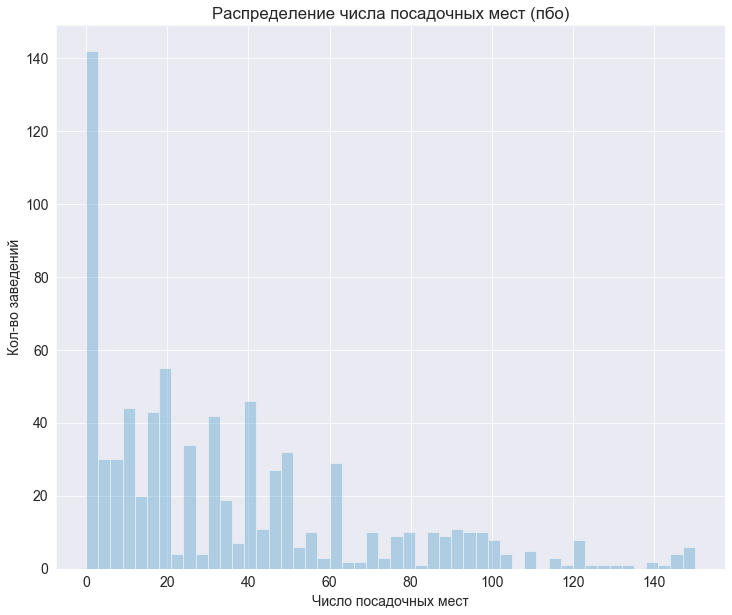

Числовое описание данных распределения посадочных мест (пбо)
count    771.000000
mean      34.784695
std       34.356804
min        0.000000
25%        8.000000
50%       25.000000
75%       50.000000
max      150.000000
Name: number, dtype: float64


In [41]:
result = []

for object_type in ['кафе', 'ресторан', 'пбо']:
    data = chain_data_co.query('object_type == @object_type')
    
    q3 = data['number'].describe()[6]
    
    number = data[data['number'] <= 3*q3]['number'] # в данном случае up_rate = 3. Этот параметр можно менять
    
    median = number.describe()[5]
    result.append([object_type, median])
    
    distplot_func(
        a=number,
        title='Распределение числа посадочных мест ({})'.format(object_type),
        xlabel='Число посадочных мест',
        ylabel='Кол-во заведений'
    )
    
    print('Числовое описание данных распределения посадочных мест ({})'.format(object_type))
    print(number.describe())

Результирующие число посадочных мест

In [42]:
result

[['кафе', 38.0], ['ресторан', 88.0], ['пбо', 25.0]]

Визуализируем результирующее число посадочных мест с помощью <code>barplot_func</code>

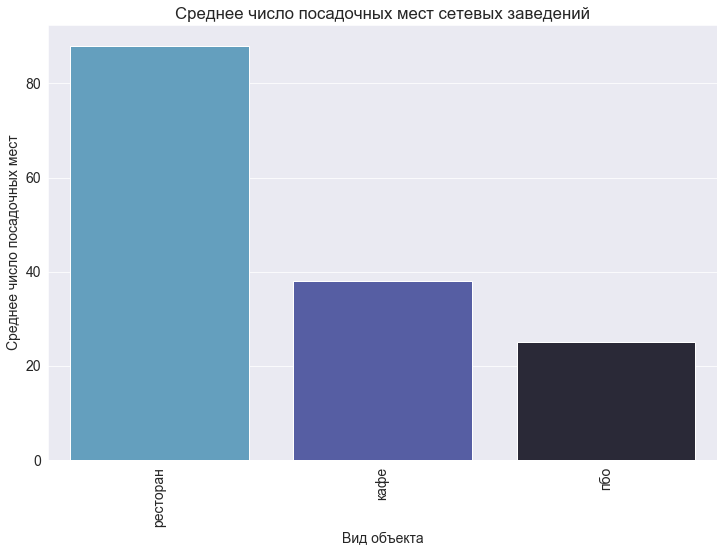

In [43]:
barplot_func(
    pd.DataFrame(result, columns=['object_type', 'mean_number']).sort_values(by='mean_number', ascending=False),
    x='object_type',
    y='mean_number',
    title='Среднее число посадочных мест сетевых заведений',
    xlabel='Вид объекта',
    ylabel='Среднее число посадочных мест'
)

**Выводы**

* Для сетевых ресторанов также характерно более высокое число посадочных мест относительно кафе и предприятия быстрого обслуживания

#### Характерные особеннсоти объектов в разрезе их вида <a id="task_4"></a>

Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Задача практически аналогична той, что решали в предыдущем пункте, правда без выделения сетевой принадлежности. Также по аналогии будем соханять результат в <code>result</code>

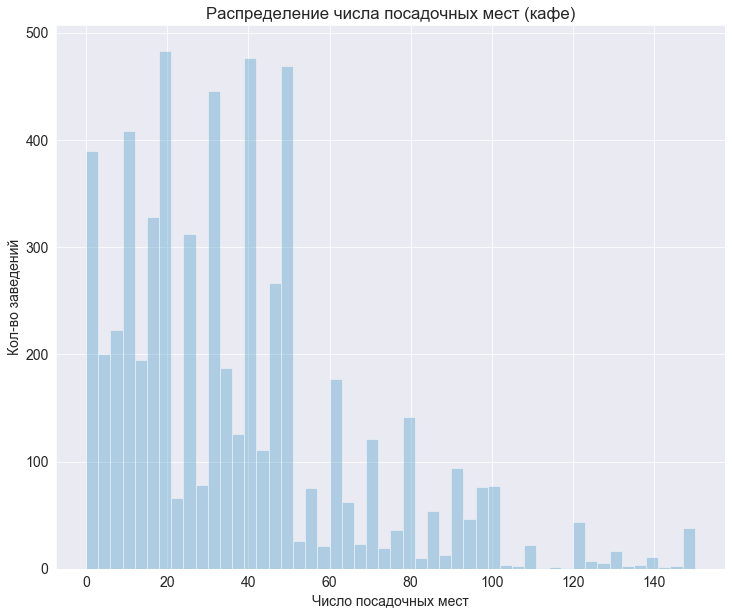

Числовое описание данных распределения посадочных мест (кафе)
count    6005.000000
mean       36.876270
std        29.225652
min         0.000000
25%        15.000000
50%        30.000000
75%        50.000000
max       150.000000
Name: number, dtype: float64


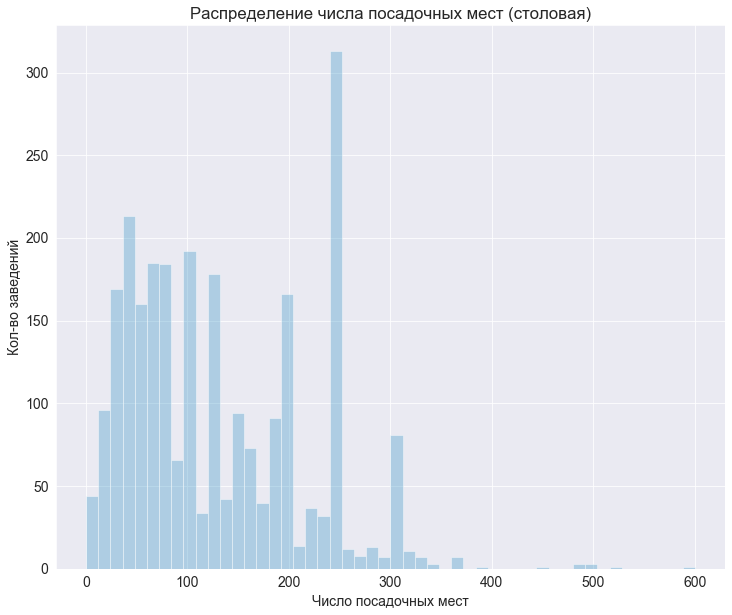

Числовое описание данных распределения посадочных мест (столовая)
count    2582.000000
mean      128.650658
std        86.931488
min         0.000000
25%        50.000000
50%       103.000000
75%       200.000000
max       600.000000
Name: number, dtype: float64


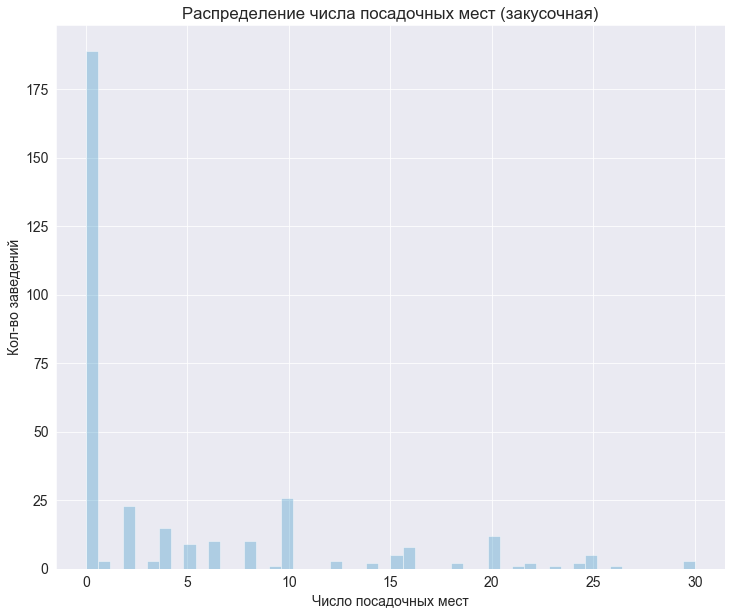

Числовое описание данных распределения посадочных мест (закусочная)
count    336.000000
mean       4.440476
std        7.056025
min        0.000000
25%        0.000000
50%        0.000000
75%        6.500000
max       30.000000
Name: number, dtype: float64


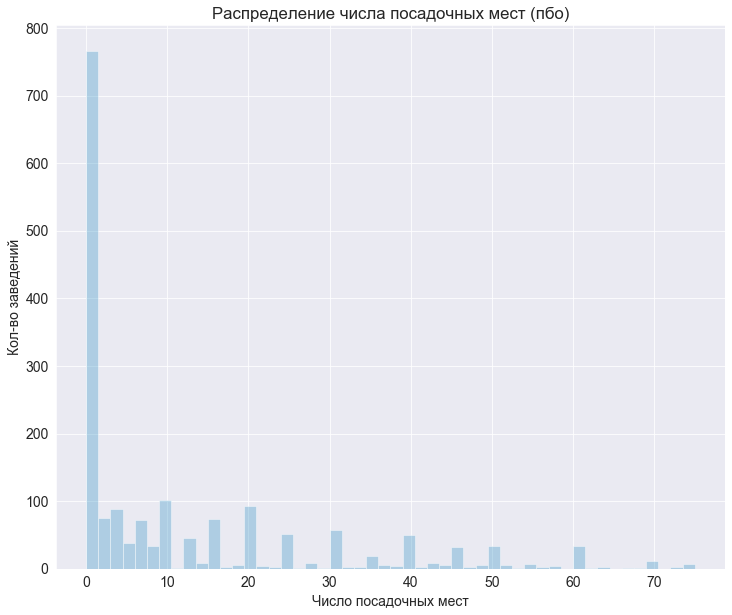

Числовое описание данных распределения посадочных мест (пбо)
count    1782.000000
mean       12.341751
std        17.341581
min         0.000000
25%         0.000000
50%         4.000000
75%        20.000000
max        75.000000
Name: number, dtype: float64


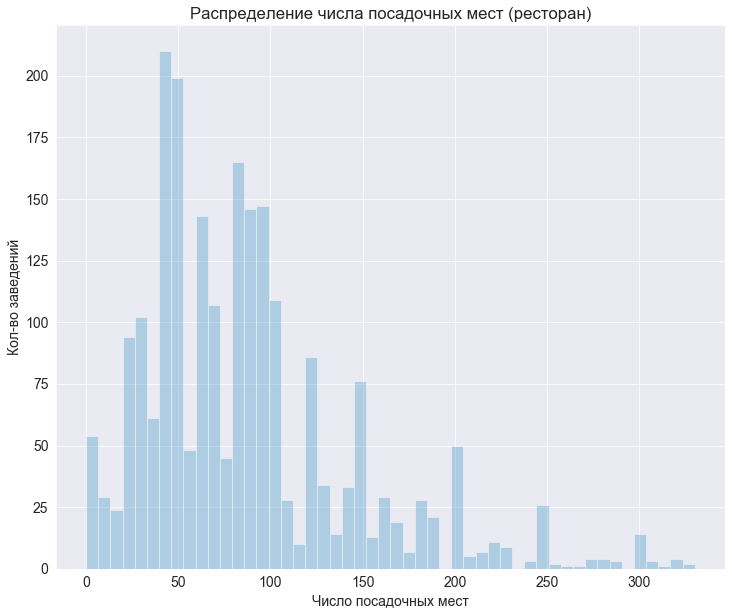

Числовое описание данных распределения посадочных мест (ресторан)
count    2231.000000
mean       86.635141
std        58.478999
min         0.000000
25%        45.000000
50%        79.000000
75%       100.000000
max       330.000000
Name: number, dtype: float64


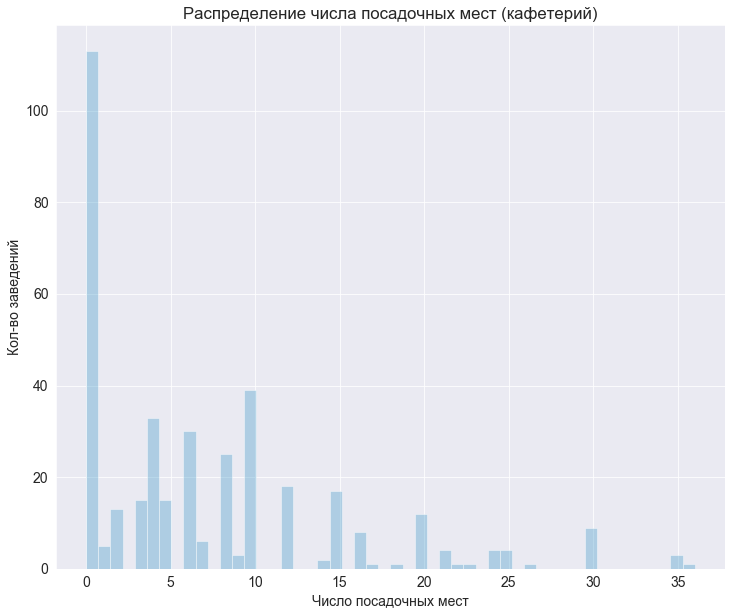

Числовое описание данных распределения посадочных мест (кафетерий)
count    384.000000
mean       7.255208
std        7.849264
min        0.000000
25%        0.000000
50%        5.000000
75%       10.000000
max       36.000000
Name: number, dtype: float64


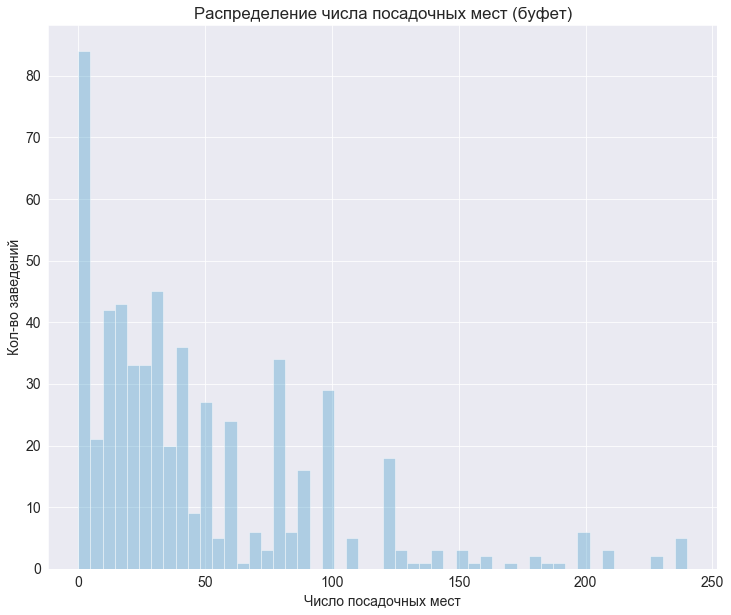

Числовое описание данных распределения посадочных мест (буфет)
count    575.000000
mean      47.240000
std       48.267274
min        0.000000
25%       14.000000
50%       30.000000
75%       73.500000
max      240.000000
Name: number, dtype: float64


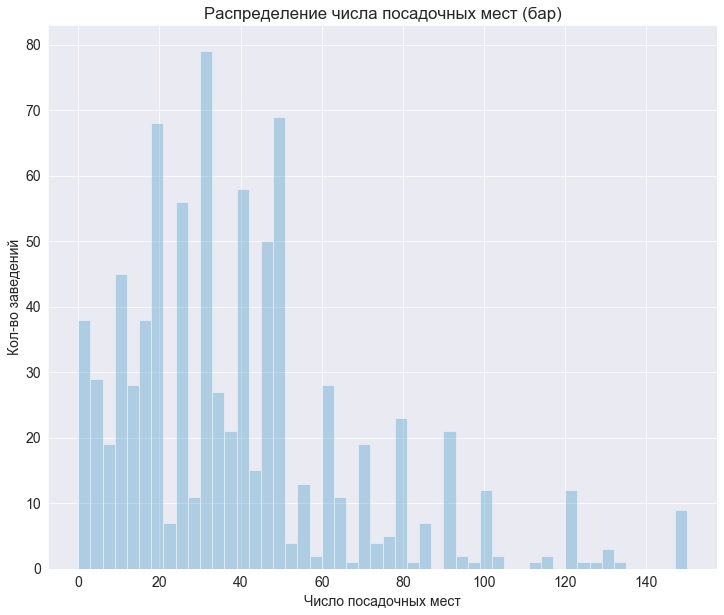

Числовое описание данных распределения посадочных мест (бар)
count    844.000000
mean      39.225118
std       29.392973
min        0.000000
25%       20.000000
50%       34.000000
75%       50.000000
max      150.000000
Name: number, dtype: float64


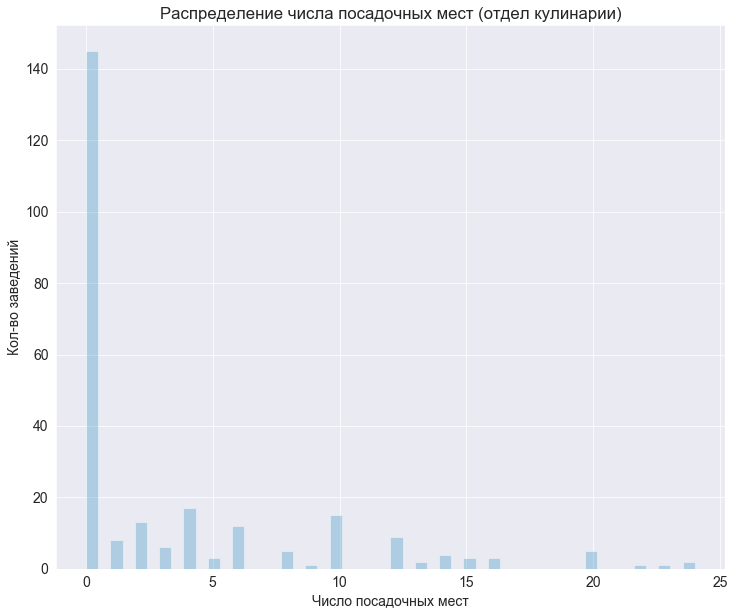

Числовое описание данных распределения посадочных мест (отдел кулинарии)
count    255.000000
mean       3.458824
std        5.530630
min        0.000000
25%        0.000000
50%        0.000000
75%        5.000000
max       24.000000
Name: number, dtype: float64


In [44]:
# чтобы не выводить лишнее сразу отсекаем по 3*q3 - эта граница приемлема для всех object_type
result = []

for object_type in data_co['object_type'].unique():
    data = data_co.query('object_type == @object_type')
    
    q3 = data['number'].describe()[6]
    
    number = data[data['number'] <= 3*q3]['number'] # в данном случае up_rate = 3. Этот параметр можно менять
    
    median = number.describe()[5]
    result.append([object_type, median])
    
    distplot_func(
        a=number,
        title='Распределение числа посадочных мест ({})'.format(object_type),
        xlabel='Число посадочных мест',
        ylabel='Кол-во заведений'
    )
    
    print('Числовое описание данных распределения посадочных мест ({})'.format(object_type))
    print(number.describe())

Результирующее число посадочных мест

In [45]:
result

[['кафе', 30.0],
 ['столовая', 103.0],
 ['закусочная', 0.0],
 ['пбо', 4.0],
 ['ресторан', 79.0],
 ['кафетерий', 5.0],
 ['буфет', 30.0],
 ['бар', 34.0],
 ['отдел кулинарии', 0.0]]

Визуализируем полученный результат

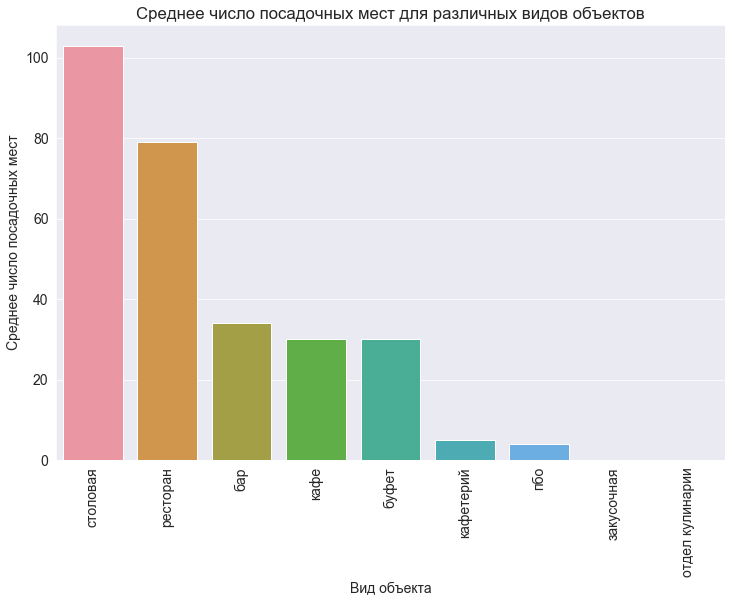

In [46]:
barplot_func(
    pd.DataFrame(result, columns=['object_type', 'mean_number']).sort_values(by='mean_number', ascending=False),
    x='object_type',
    y='mean_number',
    title='Среднее число посадочных мест для различных видов объектов',
    xlabel='Вид объекта',
    ylabel='Среднее число посадочных мест'
)

**Вывод**

* Наибольшее число посадочных мест характерно для столовой и ресторана - в среднем 100 и 80 соответственно
* Бар, кафе и буфет имеют сравнимые кол-во посадочных мест - от 30 до 35 в среднем
* Для остальных типов объектов характерно среднее число посадочных мест до 5

#### Популярные улицы и районы Москвы среди объектов <a id="task_5"></a>

Взглянем на 3 рандомные строки <code>data_co</code>

In [47]:
data_co.sample(3)

,id,object_name,chain,object_type,address,number,coordinates,address_det,street,district
3320,28546,столовая при школе интернат № 53,нет,столовая,"город Москва, Кирпичная улица, дом 18",150,37.728658 55.776801,"Россия, Москва, Кирпичная улица, 18",['Кирпичная улица'],"['Восточный административный округ', 'район Со..."
559,81473,черчилль паб,нет,ресторан,"город Москва, Ленинградский проспект, дом 66",45,37.52598 55.802725,"Россия, Москва, Ленинградский проспект, 66",['Ленинградский проспект'],"['Северный административный округ', 'район Аэр..."
9859,170522,донар кебаб,нет,пбо,"город Москва, улица Шверника, дом 13, корпус 1",0,37.589096 55.691679,"Россия, Москва, улица Шверника, 13к1",['улица Шверника'],"['Юго-Западный административный округ', 'Акаде..."


Обычно, Яндекс определяет район в следующем формате:

* Округ
* Район
* Микрорайон, жк, квартал и пр.

Разделим <code>district</code> по разделителю ',' и определим округ и район

In [48]:
def region(district):
    # удаляем ненужные символы
    district = re.sub(r"[\[\]\']", "", district)
    
    # разделяем строку по ","
    district_lst = district.split(',')
    
    return district_lst[0]


def main_district(district):
    # удаляем ненужные символы
    district = re.sub(r"[\[\]\']", "", district)
    
    # разделяем строку по ","
    district_lst = district.split(',')
    
    if len(district_lst) > 1:
        return district_lst[1]
    
    return district_lst[0]

In [49]:
data_co['region'] = data_co['district'].apply(region)
data_co['main_district'] = data_co['district'].apply(main_district)

In [50]:
data_co.sample(3)

,id,object_name,chain,object_type,address,number,coordinates,address_det,street,district,region,main_district
2622,136513,mushrooms,нет,ресторан,"город Москва, улица Большая Якиманка, дом 22",80,37.614545 55.738216,"Россия, Москва, улица Большая Якиманка, 22",['улица Большая Якиманка'],"['Центральный административный округ', 'район ...",Центральный административный округ,район Якиманка
5715,73438,ганс и марта,да,ресторан,"город Москва, Салтыковская улица, дом 15Г",120,37.867241 55.737588,"Россия, Москва, Салтыковская улица, 15Г",['Салтыковская улица'],"['Восточный административный округ', 'район Но...",Восточный административный округ,район Новокосино
10523,174059,пивной бар,нет,бар,"город Москва, улица Сергея Эйзенштейна, дом 2",12,37.646965 55.830291,"Россия, Москва, улица Сергея Эйзенштейна, 2",['улица Сергея Эйзенштейна'],"['Северо-Восточный административный округ', 'р...",Северо-Восточный административный округ,район Ростокино


Определим ТОП-5 самых популярных округов относительно числа заведений

In [51]:
data_co.groupby('region')['id'].count().reset_index().sort_values(by='id', ascending=False).head(5)

,region,id
21,Центральный административный округ,4174
25,Южный административный округ,1859
19,Северо-Восточный административный округ,1432
18,Северный административный округ,1379
9,Западный административный округ,1221


Визуализируем результаты с помощью <code>barplot_func</code>

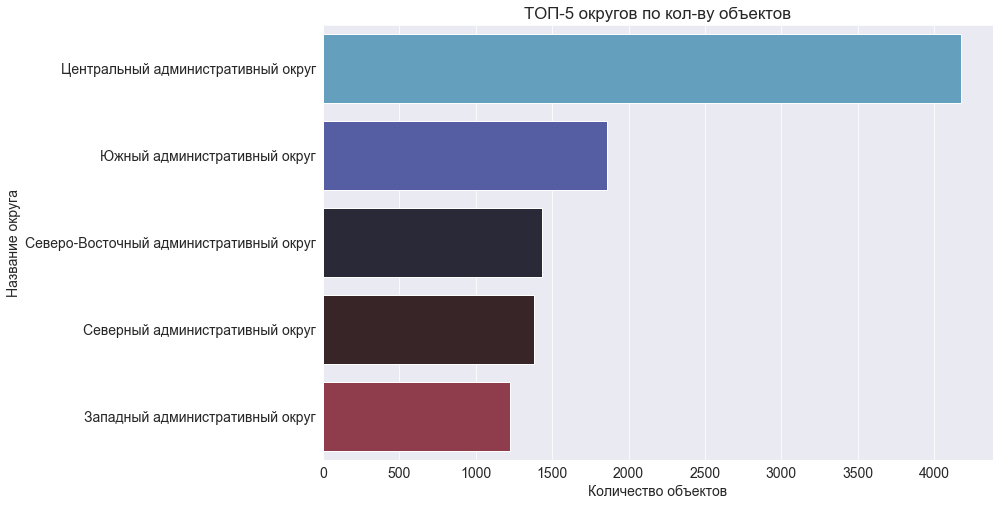

In [52]:
barplot_func(
    data=data_co.groupby('region')['id'].count().reset_index().sort_values(by='id', ascending=False).head(5),
    x='id',
    y='region',
    rotation=0,
    title='ТОП-5 округов по кол-ву объектов',
    xlabel='Количество объектов',
    ylabel='Название округа'
)

Выделим топ-10 улиц по количеству объектов общественного питания. Сгруппируем данные по <code>street</code>, посчитаем кол-во заведений на каждой улице и определим район

In [53]:
group_street_data = (
    data_co
    .groupby('street')
    .agg({'id':'count','main_district':'first', 'region':'first'})
    .reset_index()
)

group_street_data.sort_values(by='id', ascending=False).head(11)

,street,id,main_district,region
1911,[],379,район Капотня,Юго-Восточный административный округ
1434,['проспект Мира'],204,Мещанский район,Центральный административный округ
1031,['Профсоюзная улица'],183,Академический район,Юго-Западный административный округ
697,['Ленинградский проспект'],173,район Беговой,Северный административный округ
1014,['Пресненская набережная'],167,Пресненский район,Центральный административный округ
398,['Варшавское шоссе'],162,Донской район,Южный административный округ
700,['Ленинский проспект'],148,район Якиманка,Центральный административный округ
1430,['проспект Вернадского'],132,Гагаринский район,Юго-Западный административный округ
687,['Кутузовский проспект'],114,район Фили-Давыдково,Западный административный округ
605,['Каширское шоссе'],112,район Нагатино-Садовники,Южный административный округ


Как уже отмечалось пустые [] символизируют особенности адреса - эти заведения находятся в поселках или, например, в Зеленограде, где нет такого понятия, как улица. Поэтому список ТОП-10 популярных улиц:

In [54]:
top_ten_street = group_street_data.sort_values(by='id', ascending=False).head(11)[1:]

top_ten_street

,street,id,main_district,region
1434,['проспект Мира'],204,Мещанский район,Центральный административный округ
1031,['Профсоюзная улица'],183,Академический район,Юго-Западный административный округ
697,['Ленинградский проспект'],173,район Беговой,Северный административный округ
1014,['Пресненская набережная'],167,Пресненский район,Центральный административный округ
398,['Варшавское шоссе'],162,Донской район,Южный административный округ
700,['Ленинский проспект'],148,район Якиманка,Центральный административный округ
1430,['проспект Вернадского'],132,Гагаринский район,Юго-Западный административный округ
687,['Кутузовский проспект'],114,район Фили-Давыдково,Западный административный округ
605,['Каширское шоссе'],112,район Нагатино-Садовники,Южный административный округ
617,['Кировоградская улица'],110,район Чертаново Центральное,Южный административный округ


Визуализируем ТОП-10 популярных улиц с помощью <code>barplot_func</code>

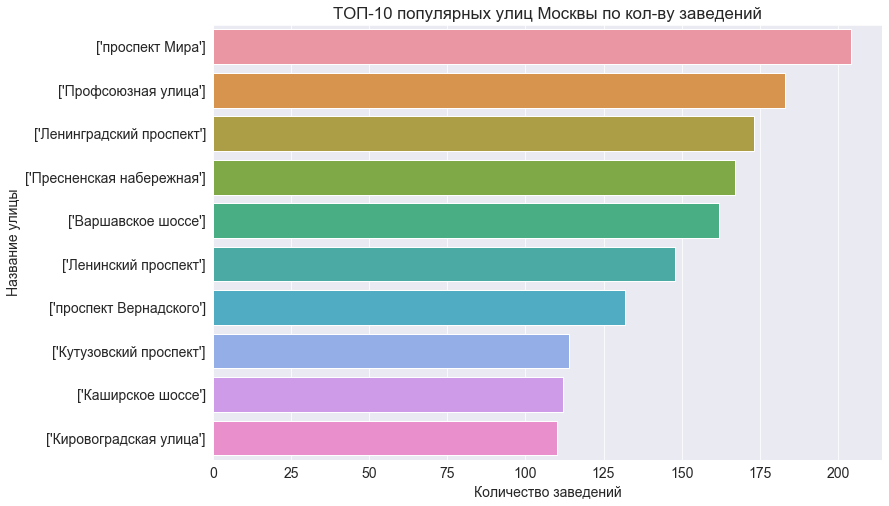

In [55]:
barplot_func(
    data=top_ten_street,
    x='id',
    y='street',
    rotation=0,
    title='ТОП-10 популярных улиц Москвы по кол-ву заведений',
    xlabel='Количество заведений',
    ylabel='Название улицы'
)

Дополнительно сгруппируем улицы по округам

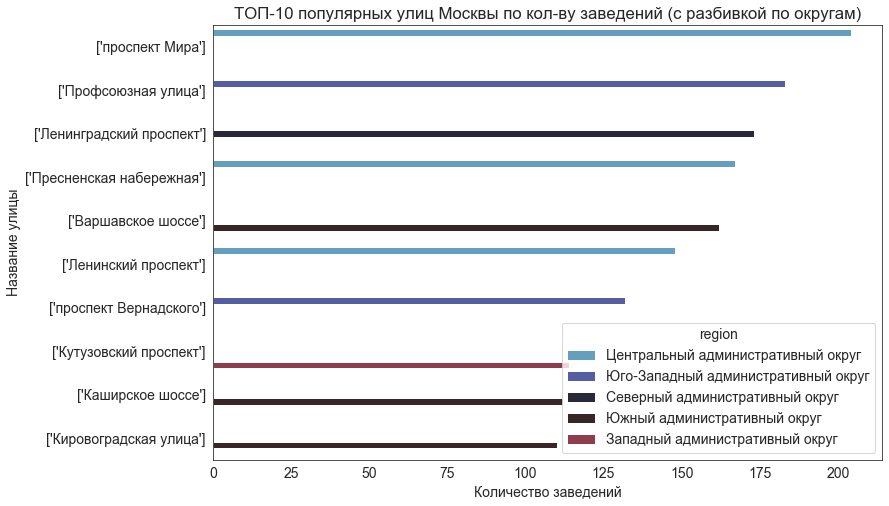

In [56]:
barplot_func(
    data=top_ten_street,
    x='id',
    y='street',
    rotation=0,
    title='ТОП-10 популярных улиц Москвы по кол-ву заведений (с разбивкой по округам)',
    xlabel='Количество заведений',
    ylabel='Название улицы',
    hue='region',
    hue_bol=True,
    style='white'
)

**Выводы**

* Самый популярный округ - ЦАО, он опережает ближайших конкурентов более чем в 2 раза по кол-ву заведений
* Самая популярная улица по кол-ву заведений - проспект Мира с числом объектов более 200
* 5 из 10 улиц ТОПа-10 являются проспектами. Как правило, проспекты - длинные, прямые и широкие улицы в городе. По таким дорогам проезжает большое число машин в день и проходит большое кол-во пешеходов, что позволяет владельцам заведений получать больше клиентов и поэтому делает этот тип улиц популярнее остальных
* Улицы из ТОП-10 расположены в разных районах Москвы, однако среди округов лидерами являются ЦАО и ЮАО, которым соответствуют по 3 улицы из ТОПа соответственно

#### Районы Москвы с преобладающим числом одного заведения на одной улице <a id="task_6"></a>

Выделим из <code>group_street_data</code> улицы, с кол-вом заведений = 1 в <code>bottom_street</code>

In [57]:
bottom_street = group_street_data[group_street_data['id'] == 1][['street', 'main_district', 'region']].reset_index(drop=True)

bottom_street.sample(3)

,street,main_district,region
281,['Мирской переулок'],Савёловский район,Северный административный округ
459,['улица Айвазовского'],район Ясенево,Юго-Западный административный округ
55,['2-й Неопалимовский переулок'],район Хамовники,Центральный административный округ


Узнаем кол-во строк в получившемся датафрейме

In [58]:
bottom_street.shape[0]

556

Сгруппируем получившийся датафрейм по району и найдем число заведений, соответствующих этим районам

In [59]:
bottom_street_district = bottom_street.groupby('main_district').agg({'street':'count', 'region':'first'}).reset_index()

bottom_street_district.sort_values(by='street', ascending=False).head(10)

,main_district,street,region
24,Таганский район,26,Центральный административный округ
89,район Хамовники,26,Центральный административный округ
0,,24,
21,Пресненский район,20,Центральный административный округ
25,Тверской район,19,Центральный административный округ
4,Басманный район,17,Центральный административный округ
59,район Марьина Роща,17,Северо-Восточный административный округ
42,район Замоскворечье,12,Центральный административный округ
14,Мещанский район,12,Центральный административный округ
56,район Лефортово,12,Юго-Восточный административный округ


Определим размер получившегося датафрейма

In [60]:
bottom_street_district.shape[0]

123

Не уверен, что определение конкретных районов даст какую-то дополнительную полезную информацию. Думаю, что более правильным будет определить ТОП-5 самых популярных округов в разрезе "одиночных" заведений

In [61]:
bottom_street_district.groupby(['region']).agg({'street':'sum'}).reset_index().sort_values(by='street', ascending=False).head(5)

,region,street
9,Центральный административный округ,168
7,Северо-Восточный административный округ,63
2,Восточный административный округ,56
10,Юго-Восточный административный округ,54
6,Северный административный округ,51


Визуализируем с помощью <code>barplot_func</code>

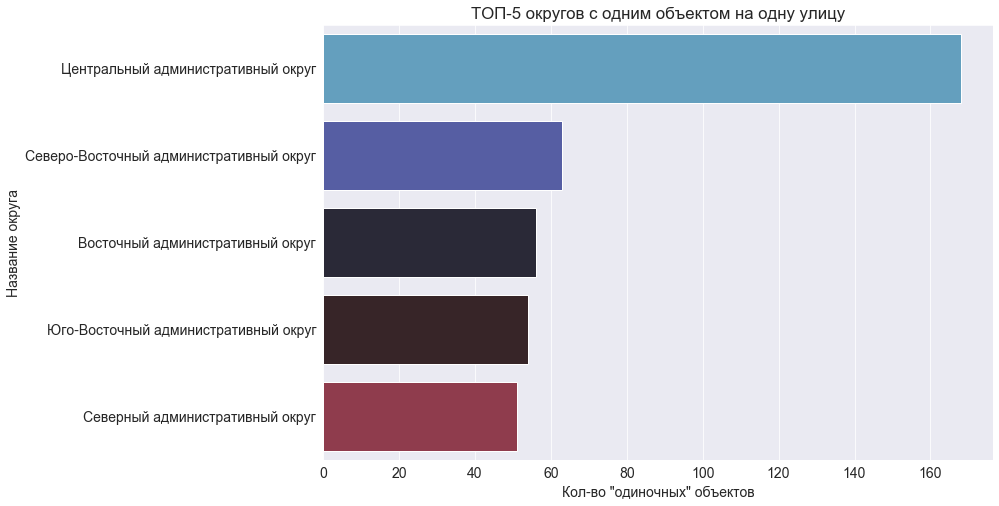

In [62]:
barplot_func(
    data=bottom_street_district.groupby(['region']).agg({'street':'sum'}).reset_index().sort_values(by='street', ascending=False).head(5),
    x='street',
    y='region',
    rotation=0,
    title='ТОП-5 округов с одним объектом на одну улицу',
    xlabel='Кол-во "одиночных" объектов',
    ylabel='Название округа'
)

**Выводы**

* Часто к районам с одним заведением на 1-у улицу относятся различные посёлки, микрорайоны, кварталы, жк, а также районы Москвы с подобными метками, что в данном анализе является излишней точностью. Проще ответить к каким округам относятся такие случаи. Большинство из них соответствуют ЦАО. Думаю, что данная особенность, скорее, связана с общей популярностью ЦАО, как округа с большим кол-вом объектов

#### Распределение количества посадочных мест для улиц с большим количеством объектов <a id="task_7"></a>

Выделим ТОП-5 самых популярных улиц и построим распределение количества посадочных мест для них

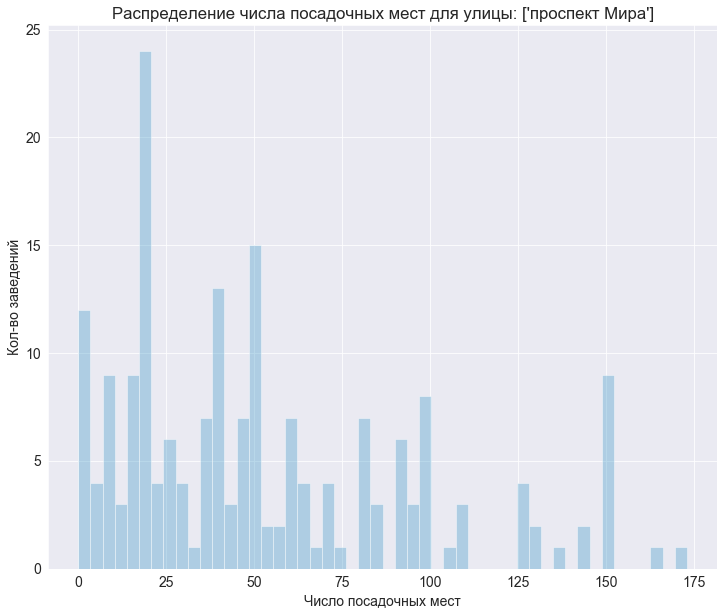

Числовое описание данных распределения посадочных мест для улицы ['проспект Мира']
count    193.000000
mean      52.849741
std       42.275180
min        0.000000
25%       20.000000
50%       43.000000
75%       80.000000
max      173.000000
Name: number, dtype: float64


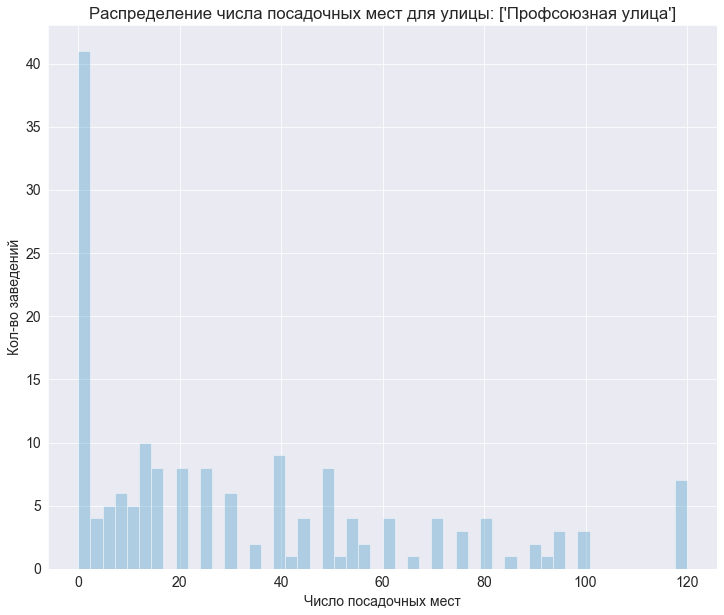

Числовое описание данных распределения посадочных мест для улицы ['Профсоюзная улица']
count    165.000000
mean      31.963636
std       33.769825
min        0.000000
25%        4.000000
50%       20.000000
75%       50.000000
max      120.000000
Name: number, dtype: float64


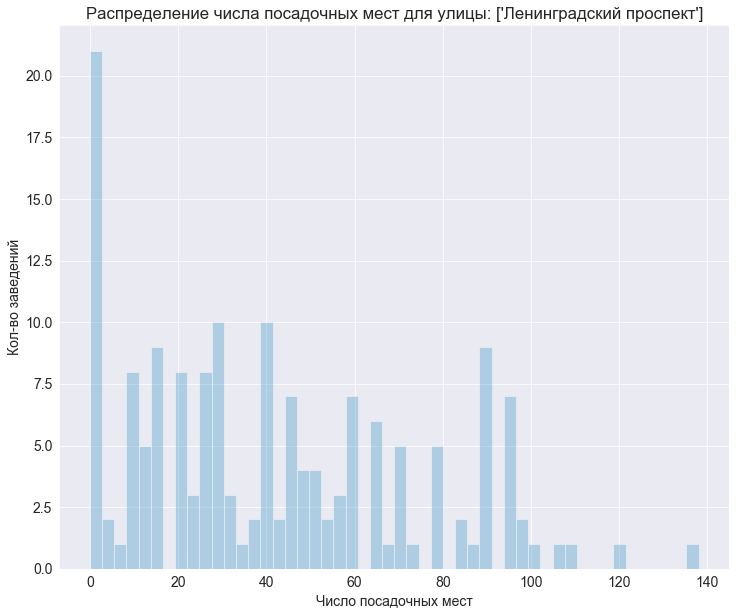

Числовое описание данных распределения посадочных мест для улицы ['Ленинградский проспект']
count    164.000000
mean      42.103659
std       32.025607
min        0.000000
25%       15.000000
50%       40.000000
75%       64.250000
max      138.000000
Name: number, dtype: float64


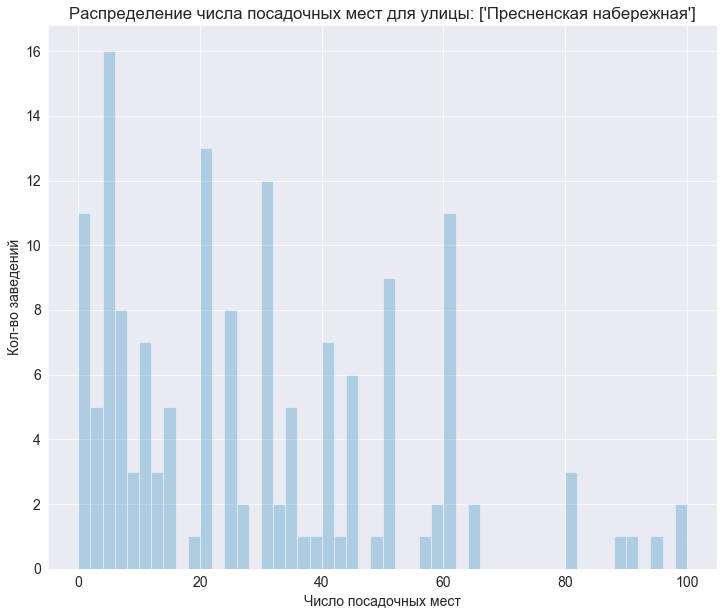

Числовое описание данных распределения посадочных мест для улицы ['Пресненская набережная']
count    151.000000
mean      28.549669
std       23.910580
min        0.000000
25%        6.500000
50%       25.000000
75%       45.000000
max      100.000000
Name: number, dtype: float64


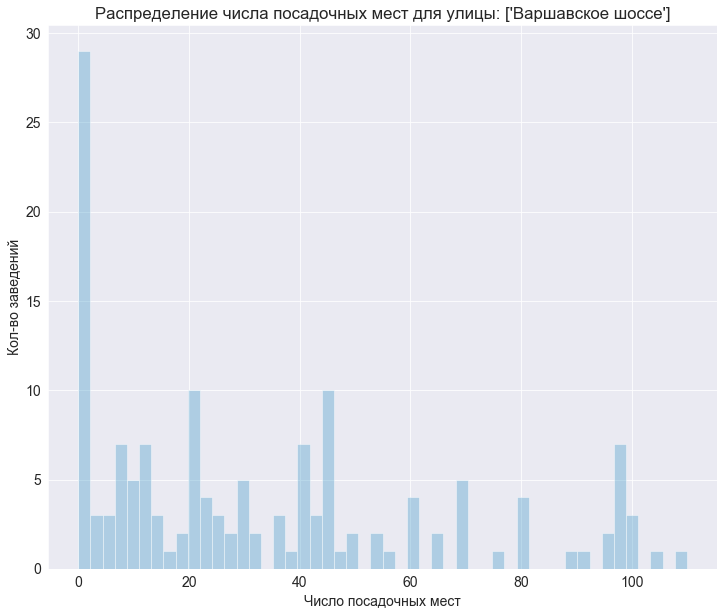

Числовое описание данных распределения посадочных мест для улицы ['Варшавское шоссе']
count    148.000000
mean      33.601351
std       31.375440
min        0.000000
25%        7.750000
50%       24.500000
75%       48.500000
max      110.000000
Name: number, dtype: float64


In [63]:
# тут для отсечения подойдет коэффициент 2
result = []

for street in top_ten_street['street'][:5]:
    data = data_co.query('street == @street')
    
    q3 = data['number'].describe()[6]
    
    number = data[data['number'] <= 2*q3]['number'] # up_rate = 2
    
    median = number.describe()[5]
    result.append([street, median])
    
    distplot_func(
        a=number,
        title='Распределение числа посадочных мест для улицы: {}'.format(street),
        xlabel='Число посадочных мест',
        ylabel='Кол-во заведений'
    )
    
    print('Числовое описание данных распределения посадочных мест для улицы {}'.format(street))
    print(number.describe())

**Выводы**

* Для ТОП-5 улиц характерной особенностью является относительно большое число (более 25% от их общего числа) объектов с низким кол-вом посадочных мест (до 10)

### Шаг 3. Выводы <a id="conclusions"></a>

* Кафе - наиболее популярный вид объектов общественного питания в Москве. Думаю, что эта популярность появилась не просто так - людям важно иметь возможность быстро и качественно перекусить, особенно во время рабочей недели. При этом кафе, зачастую, предлагают хороший уровень сервиса, приятные помещения с возможностью уединиться и поработать, чего порой может не хватать в столовой или предприятии быстрого обслуживания. Думаю, что кафе - оптимальный выбор
* Среднее число посадочных мест - от 30 до 40. Если ресторан является полноценным местом для отдыха, где люди проводят много времени (соответственно, чтобы принять всех гостей необходимо большое кол-во мест), то кафе ориентировано на недолгий перекус.  Также, возможно, будет проще с арендой (уж в материальном смысле точно)
* ЦАО является самым "популярным" округом среди объектов общественного питания. Наверное тут можно размышлять со стороны высокой конкуренции, однако я думаю, что это самый перспективный район для открытия. В округе расположено много театров, почти все московские вокзалы, значительную часть территории округа занимают различные офисные здания, а на западной окраине округа расположен «Москва-Сити». Объектов общепита тут немало, однако людей ещё больше (особенно в будние дни)
* Вряд ли можно рекомендовать улицу. Вероятнее всего конкретная улица будет определена исходя из других параметров: средней проходимости, стоимости аренды, удачного расположения близлежащих объектов и т.п. Если объект будет располагаться на популярной улице (более 100 заведений), то стоит подумать об уменьшении числа посадочных мест. На таких улицах более 25% объектов имеют кол-во посадочных мест до 10.
* О перспективах роста: в данный момент сетевая распространенность среди объектов типа кафе составляет около 25%. Возможно есть перспектива вырасти в сеть, однако явной необходимости этого замечено не было